In [1]:
import numpy as np
from PIL import Image
import sys, os
import matplotlib.pyplot as plt
from utils import *
import pickle, random
import theano as T
theano.config.floatX = 'float32'
%matplotlib inline

# Local Learning Recurrent PCA Analysis of MNIST

### One layer linear network recovers primary components of the covariance matrix

The MNIST image is represented by a vetcor 

$$x \in \Re^d$$

$$L(x,y)=\lVert x^Tx-y^Ty \rVert^2_f$$

The loss function is defined as the squared frobenius norm of the cross strain between x and y.

$$y_{t+1}=x^{T}W_{xy}-y_{t}^TW_{yy,i\neq j}$$

The activation of the hidden neurons is a linear function of the data input and other neurons in the same layer. Here lateral inhibition is used. The reason for lateral inhibition is to find a unique solution where each neuron corresponds to a primary component. Without it, the hidden layer would still learn the primary components but rotated so that each neuron would correspond to many components. 

An expectation-maximiztion algorithm is performed where the dynamics of the system are allowed to converge to a likely state and then a gradient step is taken down the loss function. Here the next frame is calculated using a scalar constant, fr.

$$fr=0.1$$

$$\hat{y}=(1-fr) y_{t-1} + y_{t}fr$$

$$\frac{\delta L}{\delta W_{yx}}\approx x^{T}y-y^{2}W_{yx}$$

The gradient of the loss function wrt the forward weights is approximated by the difference between the product of input in hidden layer activations at each synapse minus the squared hidden neuron activity multiplied by the synaptic weight.

$$\frac{\delta L}{\delta W_{yy}}\approx (1+\gamma)y^{T}y-y^{2}W_{yy}$$

Similarly, the lateral weight gradients are approximated by the difference of the neuron activations at each synapse minus the squared hidden neuron activity multiplied by the synaptic weight. Here, $\gamma$, controls the degree of lateral inhibition.

In [2]:
# load data set
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = \
    np.load('mnist.pkl')
train_x, train_y, valid_x, valid_y, test_x, test_y = [theano.shared(s) for s in 
                                                      [train_x, train_y, valid_x, valid_y, test_x, test_y]]
#train_x = np.nan_to_num((train_x - np.mean(train_x, axis=0))/np.std(train_x, axis=0))

In [3]:
class PCANet:
    def __init__(self):
            self.params = {}
            self.hyper_params = {}
            self.stats = {}
            self.fig_stats = {}
            self.exps = []
            
            
    def run_exp(self, nsamples=50000, nx=train_x.get_value().shape[1], ny=16, tol=10**-3, frames=100, fr=0.1, gamma=1,
               learning_rule=norm_update, lr=10**-3, exp_name=None, X=train_x):
        
        if exp_name == None:
            exp_name = 'pcanet_ny_' + str(ny) + '_gamma_' + str(gamma) + '_learning_rule_' + learning_rule.__name__
        plotres = nsamples/100 if nsamples >= 100 else 1
        
        # init vars
        w_yx = T.shared(rand_ortho(nx, ny))
        w_yy = T.shared(rand_ortho(ny, ny))
        y = T.shared(np.random.rand(ny))
        dw_yx = T.shared(np.zeros((nx, ny)))
        dw_yy = T.shared(np.zeros((ny, ny)))
        y_mask = T.shared(np.ones((ny, ny))-np.eye(ny))
        i = T.tensor.iscalar()
        x = T.tensor.fvector()
        
        #expectation vars and funcs
        yt = x.dot(w_yx) - y.dot(w_yy*y_mask)
        ex_updates = OrderedDict({y: (1-fr)*y + fr*yt})
        expectation = T.function([i], [yt], givens={x: X[i]}, updates=ex_updates)

        #maximization vars and funcs
        dw_yx = T.tensor.outer(x, y) - (y**2)*w_yx
        dw_yy = (1+gamma)*T.tensor.outer(y, y) - (y**2)*w_yy
        max_updates = learning_rule({w_yx: dw_yx, w_yy: dw_yy}, lr)
        maximization = T.function([i], [dw_yx, dw_yy], givens={x: X[i]}, updates=max_updates)

        #run em
        steps=[]
        deltas=[]
        Y=[]
        diffs = []
        diffsm = []
        for sample in range(nsamples):

            #expectation
            step = 0
            for f in range(frames):
                step += 1
                yex = expectation(sample)
                
                if np.sum((y.get_value()-yex)**2) < tol:
                    break

            #maximization
            if sample%plotres == 0:
                deltas += [maximization(sample)[0]]
                steps+=[step]
                Y += [y.get_value()]
            else:
                maximization(sample)
        
        #save exp params
        w_yx, w_yy = w_yx.get_value(), w_yy.get_value()
        self.params[exp_name] = [w_yx, w_yy]
        
        #save stats
        deltas = np.asarray(deltas)
        self.stats[exp_name] = {'Frame Steps': steps, 'dw norm': deltas, 'y': Y}
        
        self.hyper_params[exp_name] = {'lr': lr, 'nx': nx, 'ny': ny, 'nsamples': nsamples, 'fr': fr}
        if exp_name not in self.exps:
            self.exps += [exp_name]
        
    def plots(self, exp=None):
        if exp == None:
            exps = self.exps
        else:
            exps = [exp]
            
        for exp in exps:
            #plot fitlers
            filters = self.params[exp][0]
            nx = filters.shape[0]
            ny = filters.shape[1]
            rc=int(np.sqrt(self.hyper_params[exp]['ny']))
            fig, ax = plt.subplots(rc,rc, figsize=(10,10))
            fig.suptitle('Filters: ' + exp)
            for i in range(rc):
                for j in range(rc):
                    ax[i][j].imshow(filters.T[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)
                    
            #plot param inner product matrix
            params = self.params[exp]
            fig, ax = plt.subplots(1, len(params), figsize=(10,10))
            fig.suptitle('Inner Product Matrix: ' + exp)
            for mat, param in enumerate(params):
                ax[mat].imshow(param.T.dot(param), cmap=plt.cm.gray)
                    
            #plot stats
            fig = plt.figure(figsize=(10,5))
            fig.suptitle('Stats: ' + exp)
            stats= self.stats[exp]
            for num, stat in enumerate(stats):
                num += 1
                name, stat = stat, stats[stat]
                stat = np.asarray(stat)
                if len(stat.shape) > 2:
                    for vec in range(ny):
                        fig.add_subplot(1, len(stats), num).plot(np.linalg.norm(stat[:,vec],axis=1))
                else:
                    fig.add_subplot(1, len(stats), num).plot(stat)

                fig.add_subplot(1, len(stats), num).set_title(name)           
            
    

In [4]:
net = PCANet()

In [5]:
for g in [['0', 0], ['1', 1]]:
    net.run_exp(nsamples=10000, gamma=g[1], exp_name=g[0], tol=10**-4)

/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:97: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


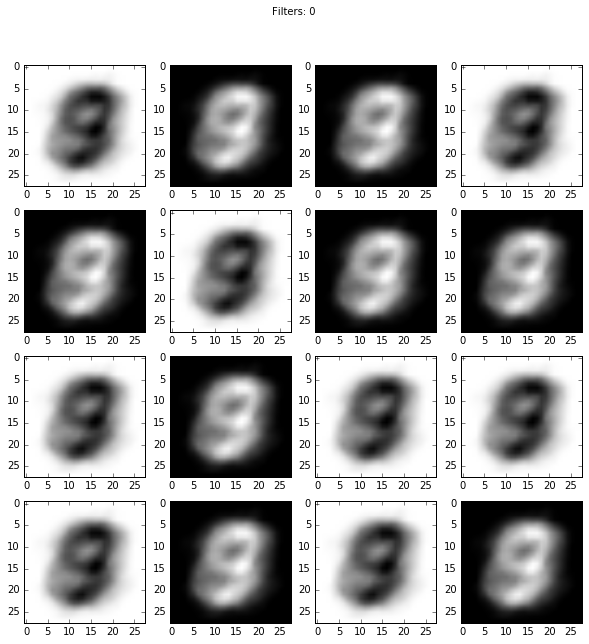

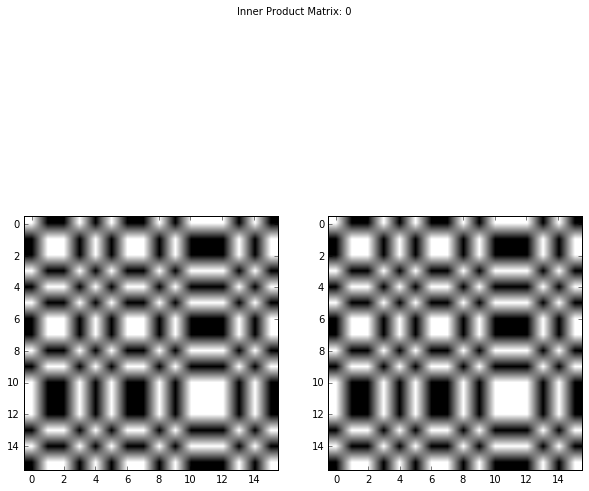

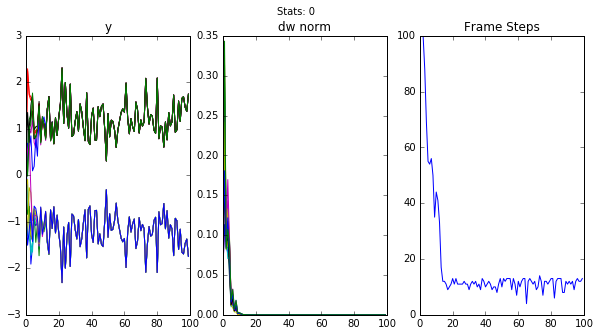

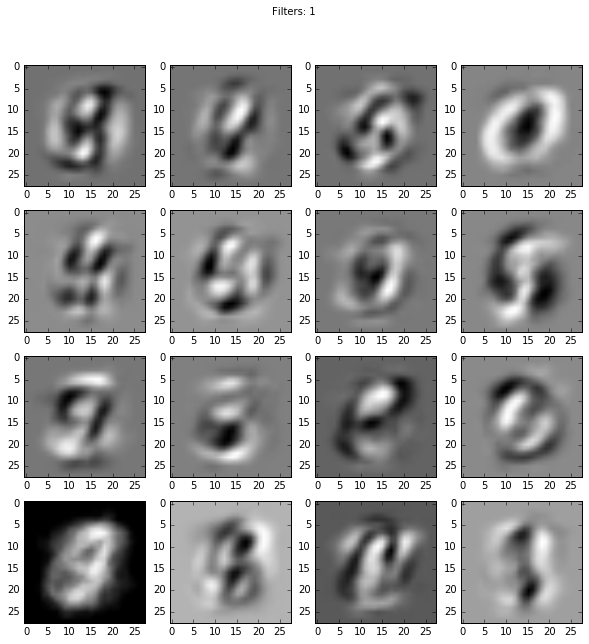

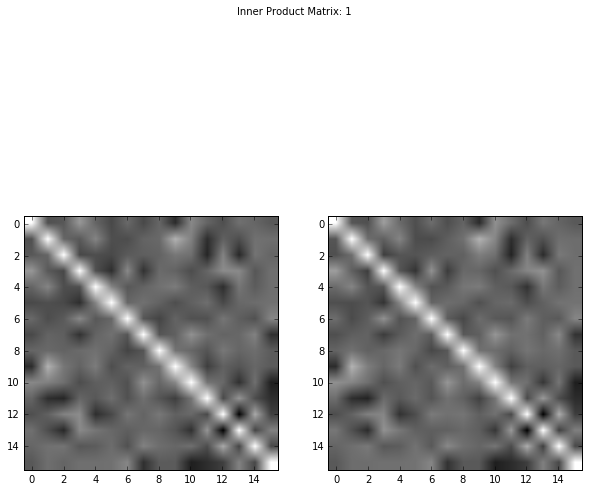

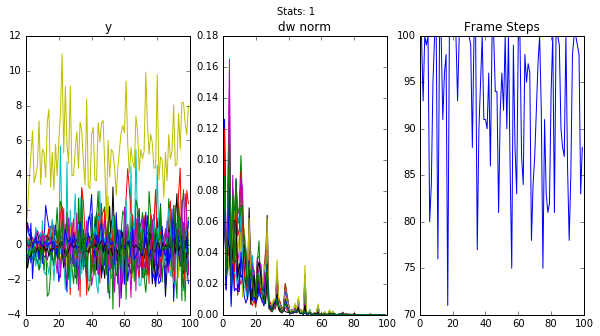

In [6]:
net.plots()

Consider pcanet with gamma equal to one.

In [107]:
exp = '1'
stats = net.stats[exp]
params = net.params[exp]
hyper_params = net.hyper_params[exp]

Mapping examples through the network and then inverting the signals is analogous to projecting examples onto the top nh primary components. 

/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


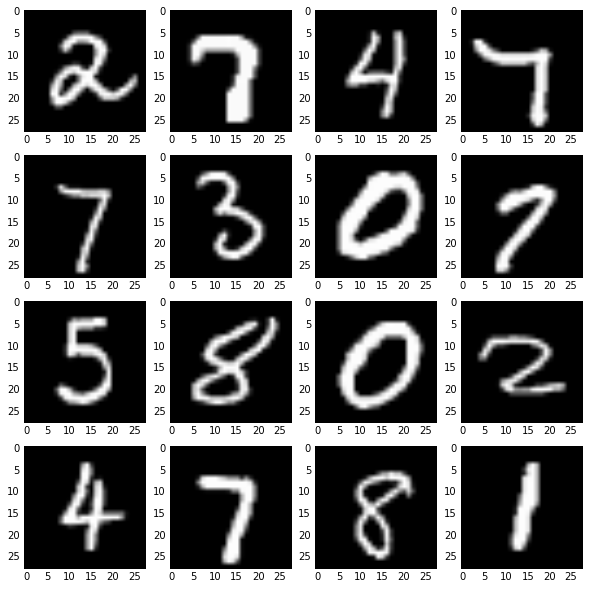

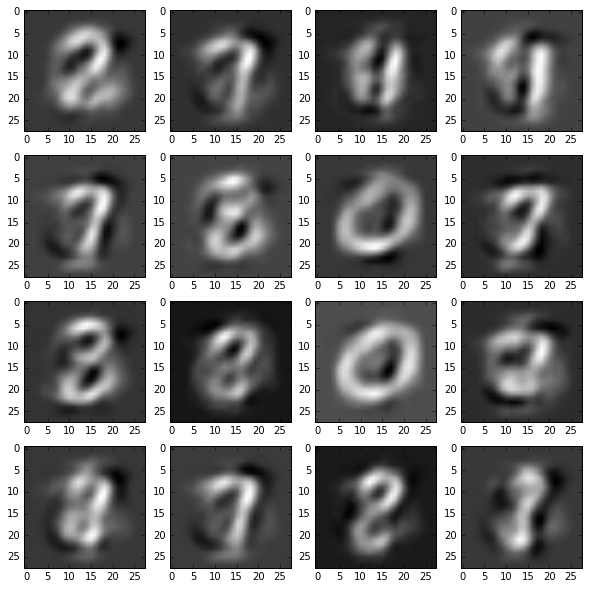

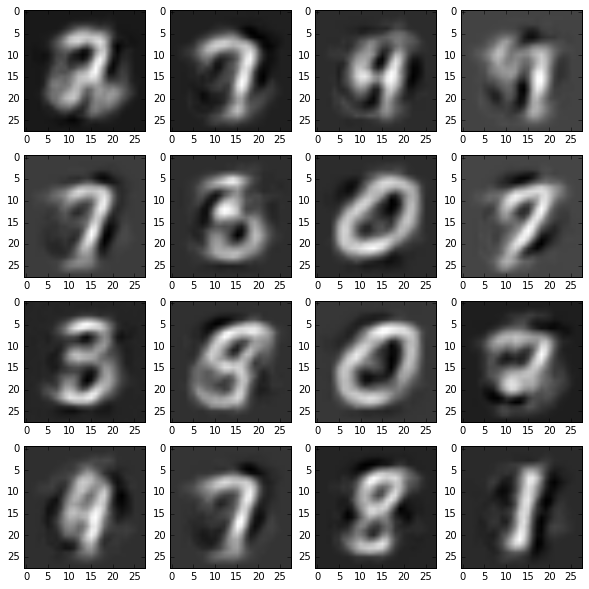

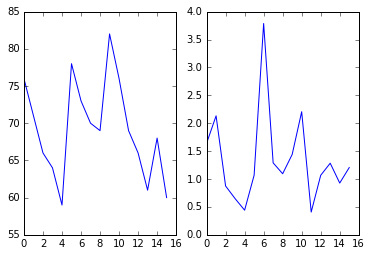

In [108]:
w_yx, w_yy = params # get model parameters
nex = hyper_params['ny'] # choose a number of examples to plot
ny, nx = hyper_params['ny'], hyper_params['nx']
examples = np.asarray(random.sample(train_x.get_value(), nex)) # randomly select samples
ex1y = examples.dot(w_yx) # compute example hidden layer activation "encode"
ex1 = ex1y.dot(w_yx.T) # invert activations "decode"
ex2 = []

# Run EM and allow y to settle before inverting.
steps = []
ex2y = []
frames = 100
tol = 10**-3
fr = 0.1
y_mask = np.ones((ny, ny))-np.eye(ny)
y = np.random.rand(ny)
for ex, x in enumerate(examples):
        #expectation
        step=0
        for f in range(frames):
            y1 = x.dot(w_yx) - y.dot(w_yy*y_mask)
            y = (1-fr)*y + fr*(y1)
            step+=1
            if np.sum((y1-y)**2) < tol:
                break
        steps += [step]
        ex2y += [y]
        ex2 += [w_yx.dot(y)]
        
ex2y = np.asarray(ex2y)
ex2 = np.asarray(ex2)

rc = int(np.sqrt(nex))
fig, ax = plt.subplots(rc, rc, figsize=(10,10))

for i in range(rc):
    for j in range(rc):
        ax[i][j].imshow(examples[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)

fig, ax = plt.subplots(rc, rc, figsize=(10,10))
for i in range(rc):
    for j in range(rc):
        ax[i][j].imshow(ex1[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)

fig, ax = plt.subplots(rc, rc, figsize=(10,10))
for i in range(rc):
    for j in range(rc):
        ax[i][j].imshow(ex2[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)
        
fig = plt.figure()
fig.add_subplot(121).plot(steps)
fig.add_subplot(122).plot(((ex1y-ex2y)**2).mean(axis=1))

SVD is used to obtin the eigenvectors and eigenvalues of the uncentered data covariance matrix, $C=\frac{1}{m}XX^{T}$.

In [109]:
X = train_x.get_value()
U, s, V = np.linalg.svd(X.T.dot(X)/X.shape[0])

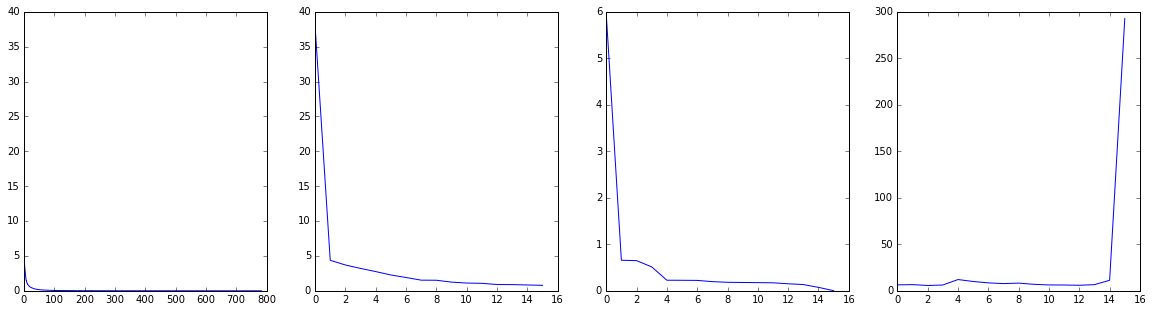

In [110]:
ys = np.asarray(stats['y'])
y_avg = np.flipud(np.sort(np.absolute(ys[-20:].mean(axis=0))))
ratio = s[:ny]/y_avg
fig = plt.figure(figsize=(20,5))
fig.add_subplot(141).plot(s)
fig.add_subplot(142).plot(s[:ny])
fig.add_subplot(143).plot(y_avg)
fig.add_subplot(144).plot(ratio)

* Fig 1 - All eigenvalues of $C$
* Fig 2 - First 16 eigenvalues of $C$
* Fig 3 - hidden layer activations
* Fig 4 - Ratio of eigenvalues to activations   

Plotted above are the eigenvalues of $C$ and the hidden layer activations for last 20 recorded samples during training. The values are approximatly proportional up to the 13th component. 

In [133]:
net.run_exp(nsamples=100, learning_rule=adam_norm, gamma=1, exp_name='adam', tol=10**-4, frames=100, lr=0.001)

In [13]:
X = train_x.get_value().T

In [30]:
Xr = X[np.nonzero(X.sum(axis=1))].T

In [31]:
U, s, V = np.linalg.svd(Xr.T.dot(Xr)/Xr.shape[0])

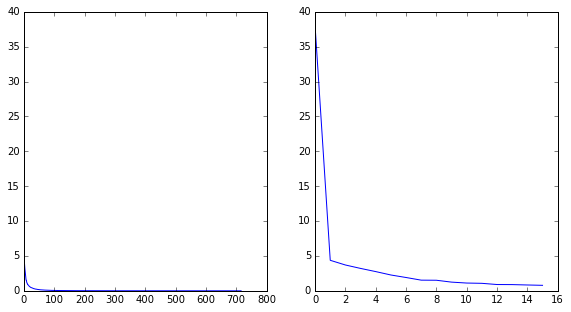

In [32]:
fig = plt.figure(figsize=(20,5))
fig.add_subplot(141).plot(s)
fig.add_subplot(142).plot(s[:16])

In [33]:
Xrn = (Xr - Xr.mean(axis=0))/Xr.std(axis=0)

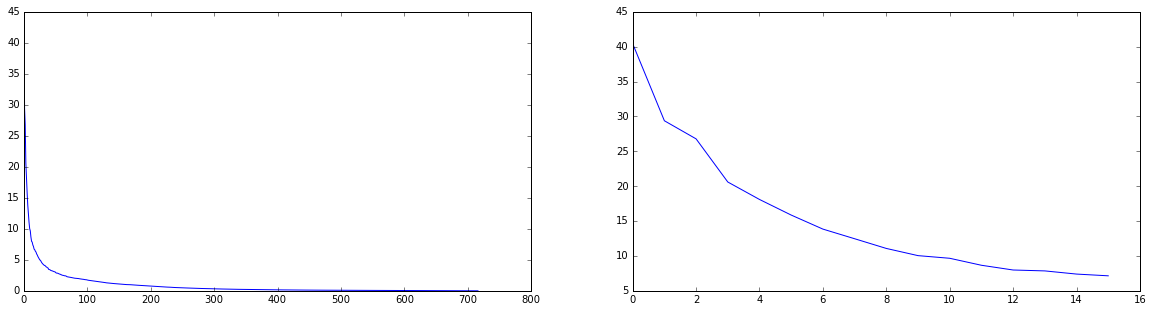

In [34]:
U, s, V = np.linalg.svd(Xrn.T.dot(Xrn)/Xrn.shape[0])
fig = plt.figure(figsize=(20,5))
fig.add_subplot(121).plot(s)
fig.add_subplot(122).plot(s[:16])

In [39]:
net = PCANet()
net.run_exp(nsamples=10000, exp_name='normdat', X=T.shared(Xrn), nx=Xrn.shape[1])